This notebook provides statistical tools to evaluate the models quantitatively.

In [1]:
# https://github.com/OpenNMT/VisTools

In [1]:
# Look at vizualizations of Sequential Neural Networks with Attention
# https://github.com/HendrikStrobelt/Seq2Seq-Vis

# Source: https://stackoverflow.com/questions/44613173/how-to-visualize-attention-weights-from-attentionwrapper
# Similar question: https://stackoverflow.com/questions/40601552/visualizing-attention-activation-in-tensorflow

# Also look at textsum automatic summarization Seq2Seq-Attention models https://github.com/rockingdingo/deepnlp/#modules

In [ ]:
# You can access attention weights by setting alignment_history=True flag in AttentionWrapper definition.

# Define attention mechanism
attn_mech = tf.contrib.seq2seq.LuongMonotonicAttention(
    num_units = attention_unit_size, memory = decoder_outputs,
    memory_sequence_length = input_lengths)

# Define attention cell
attn_cell = tf.contrib.seq2seq.AttentionWrapper(
    cell = decoder_cell, attention_mechanism = attn_mech,
    alignment_history=True)

# Define train helper
train_helper = tf.contrib.seq2seq.TrainingHelper(
    inputs = encoder_inputs, 
    sequence_length = input_lengths)

# Define decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    cell = attn_cell, 
    helper = train_helper, initial_state=decoder_initial_state)

# Dynamic decoding
dec_outputs, dec_states, _ = tf.contrib.seq2seq.dynamic_decode(decoder)

In [74]:
import numpy as np
import matplotlib.pyplot as plt

In [46]:
import os
import sys
import inspect
from pathlib import Path
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = Path(currentdir).parents[1]
sys.path.insert(1, os.path.join(parentdir, 'train'))

In [47]:
import run
import runner
import importlib
importlib.reload(run)
importlib.reload(runner)

<module 'runner' from '/Users/vesko/GitHub/UoE-dissertation/model/train/runner.py'>

In [55]:
sentences, alignments = run.main('config.yml')

INFO:tensorflow:Using config: {'_model_dir': 'run_dir/model', '_tf_random_seed': None, '_save_summary_steps': 477, '_save_checkpoints_steps': 238, '_save_checkpoints_secs': None, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 20, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 477, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2822bba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from run_dir/model/model.ckpt-10076
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:T

In [81]:
sentences[0]

'ON51 ON55 ON58 SHIFT8 OFF51 OFF55 OFF58 ON51 ON55 ON58 ON70 SHIFT4 OFF70 ON67 SHIFT2 OFF67 ON67 SHIFT2 OFF51 OFF55 OFF58 OFF67 ON51 ON55 ON58 ON63 SHIFT4 OFF63 SHIFT4 OFF51 OFF55 OFF58 ON51 ON55 ON58 SHIFT4 ON65 SHIFT2 OFF65 ON67 SHIFT2 OFF51 OFF55 OFF58 OFF67 ON51 ON55 ON58 ON65 SHIFT2 OFF65 ON65 SHIFT2 OFF65 ON65 SHIFT4 OFF51 OFF55 OFF58 OFF65 ON51 ON55 ON58 ON65 SHIFT2 OFF65 ON63 SHIFT2 OFF63 ON65 SHIFT2 OFF65 ON63 SHIFT2 OFF51 OFF55 OFF58 OFF63 ON51 ON55 ON58 SHIFT2 ON70 SHIFT2 OFF70 ON70 SHIFT2 OFF70 ON70 SHIFT2 OFF51 OFF55 OFF58 OFF70 ON51 ON55 ON58 ON70 SHIFT4 OFF70 SHIFT4 OFF51 OFF55 OFF58 ON51 ON55 ON58 ON72 SHIFT4 OFF72 ON70 SHIFT4 OFF51 OFF55 OFF58 OFF70 ON51 ON55 ON58 ON70 SHIFT4 OFF70 ON68 SHIFT2 OFF68 ON67 SHIFT2 OFF51 OFF55 OFF58 OFF67 ON51 ON55 ON58 ON63 SHIFT4 OFF63 SHIFT4 OFF51 OFF55 OFF58 ON51 ON55 ON58 SHIFT2 ON63 SHIFT2 OFF63 ON65 SHIFT2 OFF65 ON67 SHIFT2 OFF51 OFF55 OFF58 OFF67 ON51 ON55 ON58 ON65 SHIFT2 OFF65 ON70 SHIFT2 OFF70 SHIFT2 ON65 SHIFT2 OFF51 OFF55 OFF5

In [85]:
alignments[0].shape

(5, 200, 102)

In [95]:
alignments[1][0, 0:10, 0:40].shape

(10, 40)

In [87]:
# Finally, you can visualize attentions (alignments) like this:

def plot_attention(attention_map, input_tags = None, output_tags = None):    
    attn_len = len(attention_map)

    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(15, 10))
    ax = f.add_subplot(1, 1, 1)

    # Add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # Add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # Add labels
    ax.set_yticks(range(attn_len))
    if output_tags != None:
        ax.set_yticklabels(output_tags[:attn_len])

    ax.set_xticks(range(attn_len))
    if input_tags != None:
        ax.set_xticklabels(input_tags[:attn_len], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    plt.show()

# input_tags - word representation of input sequence, use None to skip
# output_tags - word representation of output sequence, use None to skip
# i - index of input element in batch

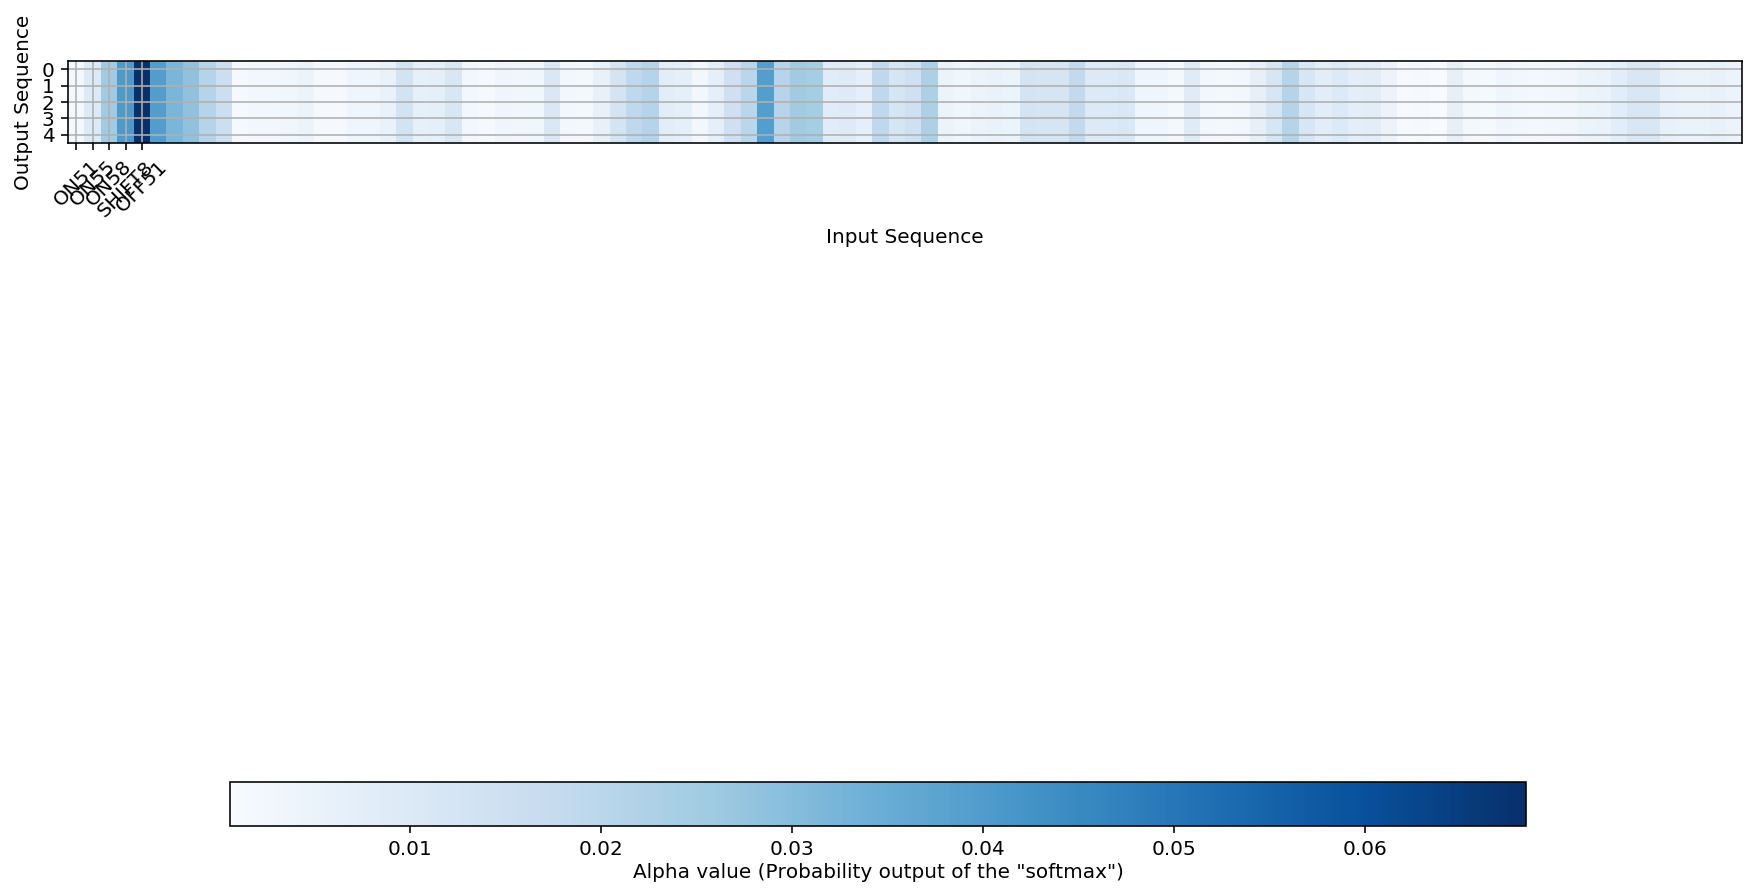

In [82]:
a = alignments[0]
input_tags = sentences[0].split()
i = 1

plot_attention(a[:, i, :], input_tags)

In [96]:
features = "SHIFT16 ON70 SHIFT12 OFF70 ON67 SHIFT4 OFF67 ON63 SHIFT8 OFF63 SHIFT16 ON65 SHIFT4 OFF65 ON67 SHIFT4 OFF67 ON65 SHIFT4 OFF65 ON65 SHIFT4 OFF65 ON65 SHIFT8 OFF65 ON65 SHIFT4 OFF65 ON63 SHIFT4 OFF63 ON65 SHIFT4 OFF65 ON63 SHIFT4 OFF63 SHIFT4 ON70 SHIFT8 OFF70 ON70 SHIFT4 OFF70 ON70 SHIFT8 OFF70 SHIFT8 ON72 SHIFT8 OFF72 ON70 SHIFT8 OFF70 ON70 SHIFT8 OFF70 ON68 SHIFT4 OFF68 ON67 SHIFT4 OFF67 ON63 SHIFT8 OFF63 SHIFT12 ON63 SHIFT4 OFF63 ON65 SHIFT4 OFF65 ON67 SHIFT4 OFF67 ON65 SHIFT4 OFF65 ON70 SHIFT4 OFF70 SHIFT4 ON65 SHIFT4 OFF65 ON65 SHIFT4 OFF65 ON63 SHIFT8 OFF63 ON70 SHIFT4 OFF70 ON70 SHIFT16 OFF70 ON70 SHIFT16 OFF70".split()
predicted_text = sentences[0].split()
input_length = len(features)+1
output_length = len(predicted_text)+1


/Users/vesko/anaconda3/envs/jupyter/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


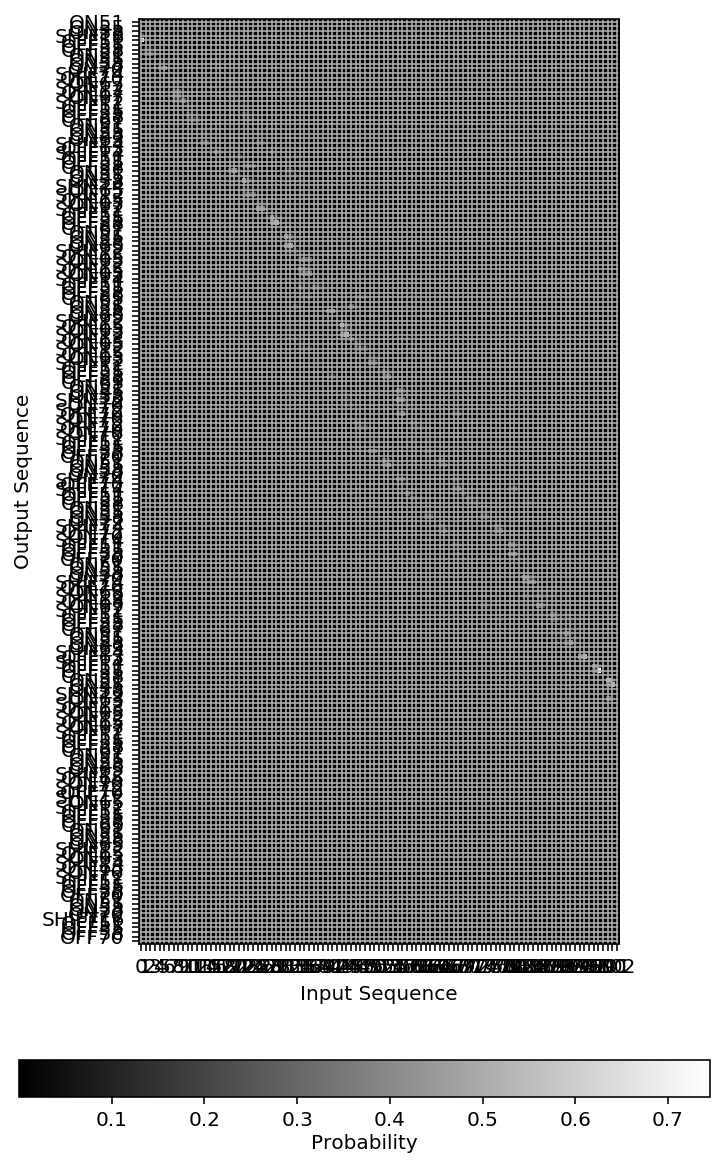

In [103]:
# get the activation map
# activation_map = np.squeeze(self.proba_model.predict(np.array([d])))[
#     0:output_length, 0:input_length]

activation_map = alignments[1][0, 0:output_length, 0:input_length]

# import seaborn as sns
plt.clf()
f = plt.figure(figsize=(8, 8.5))
ax = f.add_subplot(1, 1, 1)

# add image
i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
cbar.ax.set_xlabel('Probability', labelpad=2)

# add labels
ax.set_yticks(range(output_length))
ax.set_yticklabels(predicted_text[:output_length])

ax.set_xticks(range(input_length))
# ax.set_xticklabels(text_[:input_length], rotation=45)

ax.set_xlabel('Input Sequence')
ax.set_ylabel('Output Sequence')

# add grid and legend
ax.grid()
# ax.legend(loc='best')

f.savefig(os.path.join('activation_viz.pdf'), bbox_inches='tight')
f.show()

In [ ]:
len(a)